# Exercises

## Exercise 1: explore filter parameters
---
In this exercises you will explore how different parameters affect the filtering process.
- Import the data form `data/moving_lfp.pickle` (the file is already on your machine if you run the `download_data()` cell in the main lesson)
- Take a few seconds of the data, and filter them in different frequency bands. Plot the resulting singal.
  Fix the central frequency and play with the width of the band, then try to change the central frequency of the band.
- Change the order of the filter, keeping the frequency band fixed. How does the filtered signal change? How does the computing time change? (You can try to quantify the computing time with the jupyter magic command [`%timeit`](https://docs.python.org/3/library/timeit.html) )
- Comment on what you see

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import lfp_functions as lf

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False,
                     'image.cmap':plt.cm.jet})

In [2]:
# Download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/7BosHgemAseANIc')

In [3]:
with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


Text(0, 0.5, 'voltage (mV)')

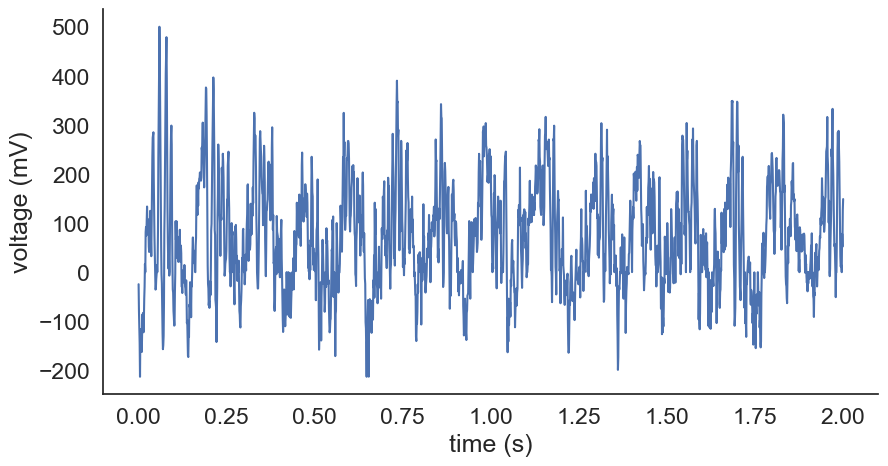

In [4]:
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,2,2000),lfp[:2000])
plt.xlabel('time (s)')
plt.ylabel('voltage (mV)')

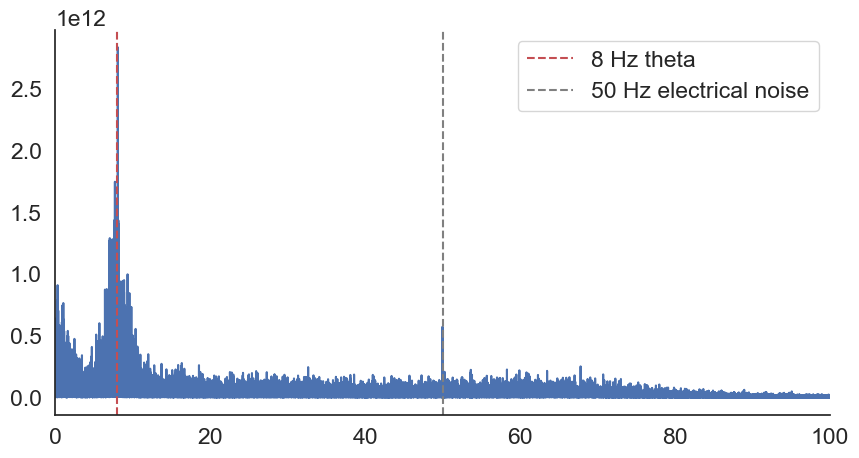

In [5]:
from scipy.fft import fft, fftfreq

n_samples = len(lfp)
sample_dt = 1. / sampling_rate

# we subtract the mean to get rid of the 0 frequency component in the spectrum
centered_lfp = lfp - np.mean(lfp)

transformed_signal = fft(centered_lfp) 

frequencies = fftfreq(n_samples,sample_dt) 

transformed_signal = transformed_signal[:n_samples//2]
frequencies = frequencies[:n_samples//2]

power = abs(transformed_signal)**2

plt.figure(figsize = (10,5))
plt.plot(frequencies,power)
plt.xlim([0,100]) # restrict to 
plt.axvline(x=8 ,c='r',linestyle='--',label='8 Hz theta')
plt.axvline(x=50 ,c='grey',linestyle='--',label='50 Hz electrical noise')

plt.legend()


Text(0, 0.5, 'voltage (mV)')

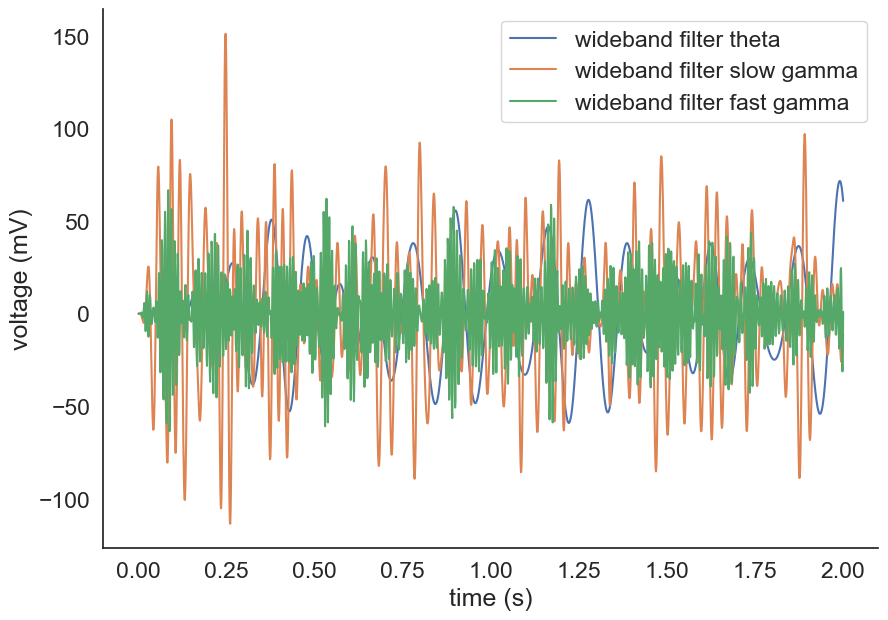

In [6]:
from scipy.signal import butter
from scipy.signal import sosfilt

filter_order = 5 #the higher the order, the sharper the filter frequency response, 
                 #but with more computations and potental numerical instability
low_f1 = 8
high_f1 = 12

low_f2 = 20
high_f2 = 45

low_f3 = 100
high_f3 = 140

#define filter object
filter1 = butter(filter_order,[low_f1,high_f1],
                btype='band', 
                output='sos', 
                fs=sampling_rate)

filter2 = butter(filter_order,[low_f2,high_f2],
                btype='band', 
                output='sos', 
                fs=sampling_rate)

filter3 = butter(filter_order,[low_f3,high_f3],
                btype='band', 
                output='sos', 
                fs=sampling_rate)
                
#apply filter to lfp       
wideband_lfp1 = sosfilt(filter1, lfp)
wideband_lfp2= sosfilt(filter2, lfp)
wideband_lfp3 = sosfilt(filter3, lfp)

plt.figure(figsize=(10,7))
plt.plot(np.linspace(0,2,2000),wideband_lfp1[:2000],label = 'wideband filter theta')
plt.plot(np.linspace(0,2,2000),wideband_lfp2[:2000],label = 'wideband filter slow gamma')
plt.plot(np.linspace(0,2,2000),wideband_lfp3[:2000],label = 'wideband filter fast gamma')
plt.xlabel('time (s)')
plt.legend()
plt.ylabel('voltage (mV)')

Text(0, 0.5, 'voltage (mV)')

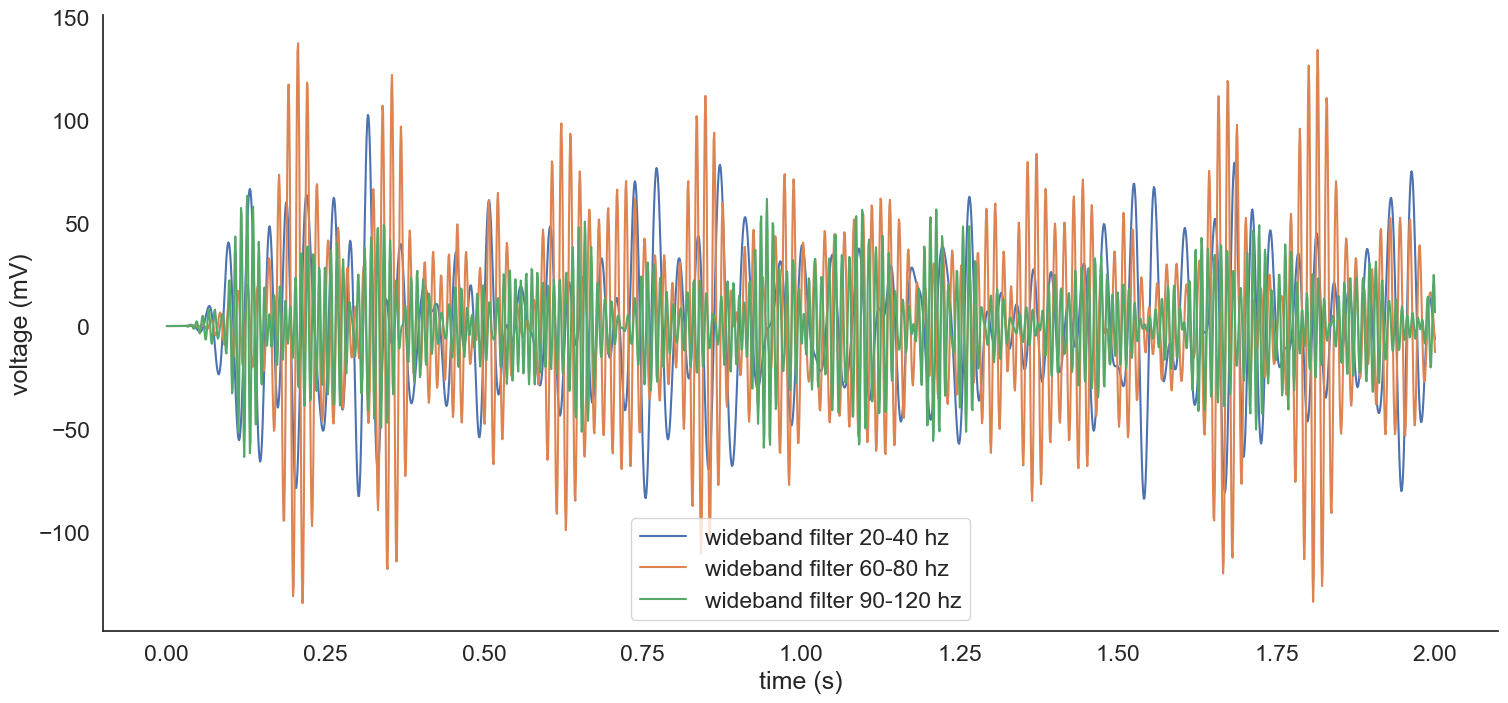

In [7]:
from scipy.signal import butter
from scipy.signal import sosfilt

filter_order = 10 #the higher the order, the sharper the filter frequency response, 
                 #but with more computations and potental numerical instability
low_f1 = 20
high_f1 = 40

low_f2 = 60
high_f2 = 80

low_f3 = 90
high_f3 = 120

#define filter object
filter1 = butter(filter_order,[low_f1,high_f1],
                btype='band', 
                output='sos', 
                fs=sampling_rate)

filter2 = butter(filter_order,[low_f2,high_f2],
                btype='band', 
                output='sos', 
                fs=sampling_rate)

filter3 = butter(filter_order,[low_f3,high_f3],
                btype='band', 
                output='sos', 
                fs=sampling_rate)
                
#apply filter to lfp       
wideband_lfp1 = sosfilt(filter1, lfp)
wideband_lfp2= sosfilt(filter2, lfp)
wideband_lfp3 = sosfilt(filter3, lfp)

plt.figure(figsize=(18,8))
plt.plot(np.linspace(0,2,2000),wideband_lfp1[:2000],label = 'wideband filter 20-40 hz')
plt.plot(np.linspace(0,2,2000),wideband_lfp2[:2000],label = 'wideband filter 60-80 hz')
plt.plot(np.linspace(0,2,2000),wideband_lfp3[:2000],label = 'wideband filter 90-120 hz')

plt.xlabel('time (s)')
plt.legend()
plt.ylabel('voltage (mV)')

When the filter order is higher, the roll-off between the passband and stopband is usually steeper. This makes the filter more selective and the transition band smaller. So, raising the order of the filter can make it so that frequencies outside the desired passband are attenuated more strongly. This can make the filtered signal cleaner by removing more of the noise from nearby frequency components. Higher-order filters, on the other hand, can cause more phase distortion, especially close to the cutoff frequencies. In general, it takes longer to do calculations when the order of the filter is raised. It takes more time and computing power to handle higher-order filters because they use more complicated mathematical operations. 

## Exercise 2: wavelet transform with real wavelets
---
In this exercises you will explore the difference between real and complex wavelets in the continous wavelet transform.
- Import the data form `data/moving_lfp.pickle`
- Select a period of a few seconds of the signal and compute the spectrogram. 
  Try the wavelet transform with wavelet `mexh` (mexican hat),`gaus` (gaussian) and `morl` (morlet). These are all real wavelets.
- What differences do you see with respect to the spectrum computed with the complex Morlet tranform ? Comment on why do you think this might be the case.

In [8]:
from scipy import signal
from pywt import scale2frequency
from pywt import cwt

In [9]:
from ipywidgets import interact
import ipywidgets as widgets


def plot_wavelet(scale,freq):
    plt.figure(figsize=(10,5))
    wavelet = signal.morlet(1000,s=scale,w=freq)
    envelope = abs(wavelet)
    plt.plot(wavelet.real,label='wavelet (real part)')
    plt.plot(envelope, label = 'envelope')
    plt.legend(loc=[1,1])
    plt.axis('off')

interact(plot_wavelet, scale = widgets.FloatSlider(min=.05, max=2, value=.5),
                       freq = widgets.FloatSlider(min=1, max=20, value=5))

interactive(children=(FloatSlider(value=0.5, description='scale', max=2.0, min=0.05), FloatSlider(value=5.0, d…

<function __main__.plot_wavelet(scale, freq)>

In [10]:
from pywt import wavelist

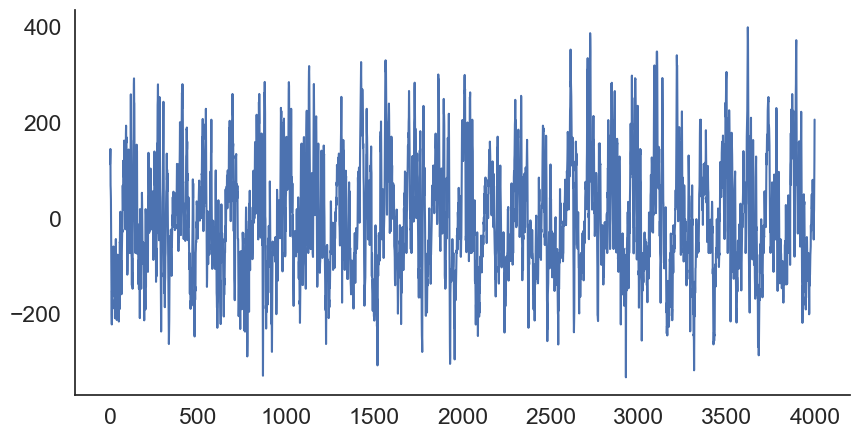

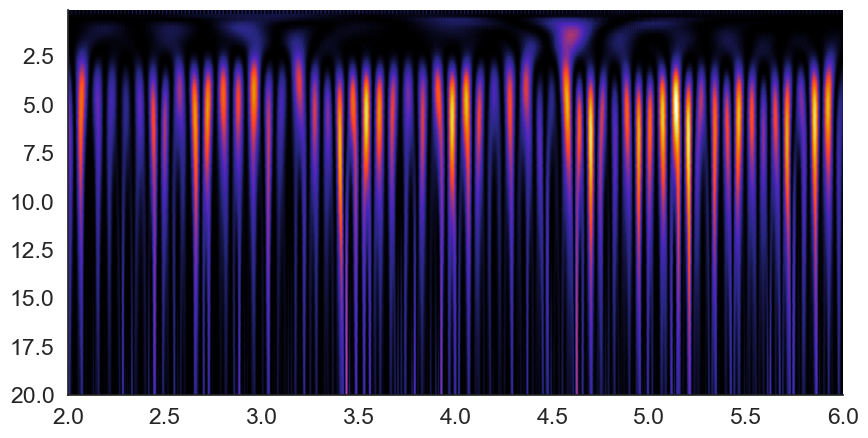

In [11]:
from pywt import scale2frequency
from pywt import cwt

start = 2 #in seconds
end = 6 # in seconds

sig = lfp[int(start*sampling_rate):int(end*sampling_rate)]
sig = sig - np.mean(sig) # get rid of 0 frequency component

plt.figure(figsize=(10,5))
plt.plot(sig)

#spectrogram with morlet transform

frequencies =  np.linspace(0.1,20,100)/sampling_rate
wavelet = 'gaus1'
scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)
plt.figure(figsize=(10,5))
plt.imshow(abs(cwtmatr)**2, extent=[start,end,frequencies[-1]*sampling_rate,
                         frequencies[0]*sampling_rate], aspect='auto', cmap='CMRmap')

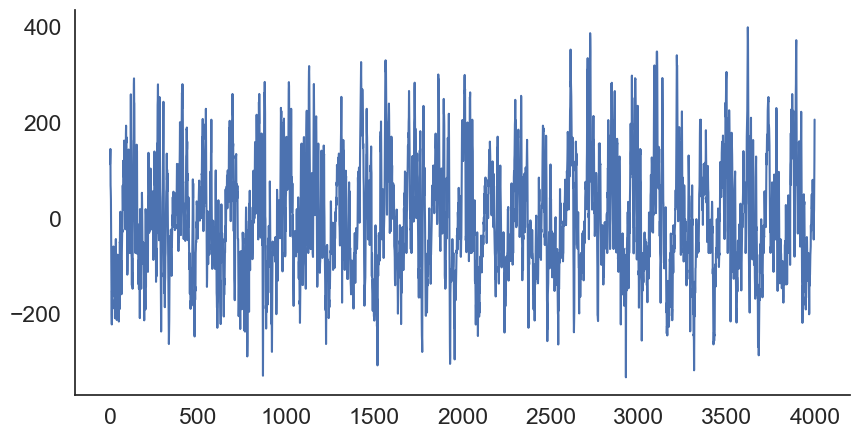

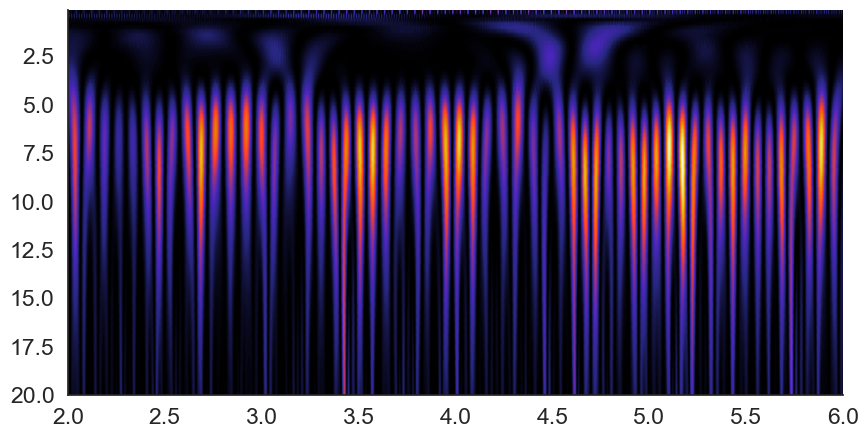

In [12]:
from pywt import scale2frequency
from pywt import cwt

start = 2 #in seconds
end = 6 # in seconds

sig = lfp[int(start*sampling_rate):int(end*sampling_rate)]
sig = sig - np.mean(sig) # get rid of 0 frequency component

plt.figure(figsize=(10,5))
plt.plot(sig)

#spectrogram with mexh transform

frequencies =  np.linspace(0.1,20,100)/sampling_rate
wavelet = 'mexh'
scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)
plt.figure(figsize=(10,5))
plt.imshow(abs(cwtmatr)**2, extent=[start,end,frequencies[-1]*sampling_rate,
                         frequencies[0]*sampling_rate], aspect='auto', cmap='CMRmap')

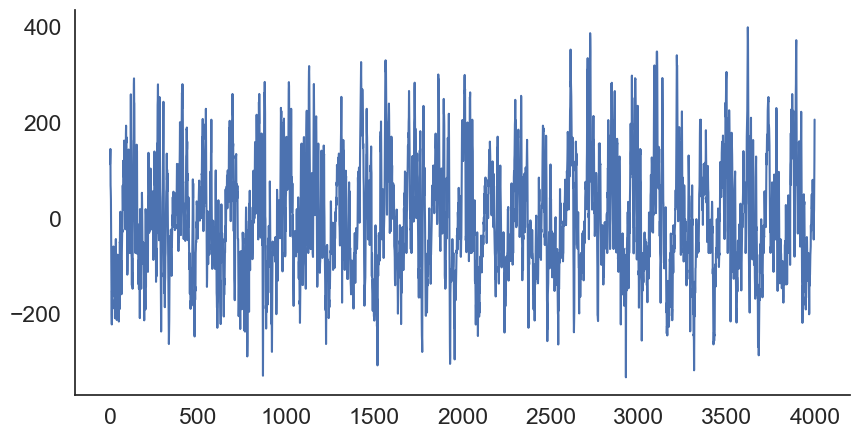

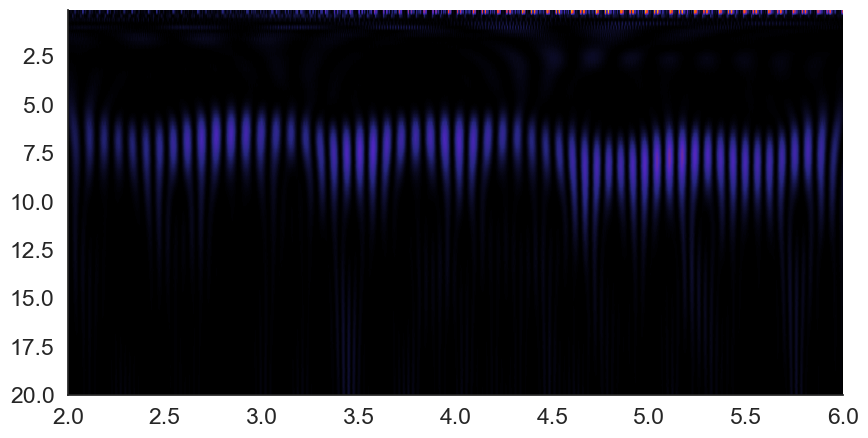

In [13]:
from pywt import scale2frequency
from pywt import cwt

start = 2 #in seconds
end = 6 # in seconds

sig = lfp[int(start*sampling_rate):int(end*sampling_rate)]
sig = sig - np.mean(sig) # get rid of 0 frequency component

plt.figure(figsize=(10,5))
plt.plot(sig)

#spectrogram with morlet transform

frequencies =  np.linspace(0.1,20,100)/sampling_rate
wavelet = 'morl'
scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)
plt.figure(figsize=(10,5))
plt.imshow(abs(cwtmatr)**2, extent=[start,end,frequencies[-1]*sampling_rate,
                         frequencies[0]*sampling_rate], aspect='auto', cmap='CMRmap')

The main lobes of real wavelets, such as the Mexican Hat and Gaussian, are wider in the frequency domain. This means that they have lower frequency resolution and a greater time-frequency localization. The Morlet wavelet, on the other hand, has smaller main lobes that make it possible to finetune frequency resolution and localize time and frequency more precisely.


## Exercise 3: REM sleep detection
---
Mammalian sleep is organized in different phases. [Rapid Eye Movement (REM) sleep](https://en.wikipedia.org/wiki/Rapid_eye_movement_sleep) is a well studied phase, with clear markers that make it detectable from LFP data. One of the most used marker is the ratio (or difference) between the oscillatory power in the theta and delta bands in the hippocampus. During REM sleep, the former dominates, in a pattern that resembles active behaviour.  
In this exercise we will use the tools we learned about to detect and inspect the REM and non-REM (nREM) phases of sleep in data recorded from the hippocampus of a sleeping mouse.

- Import the data form `data/moving_lfp.pickle`
- Compute the instantaneous power in the theta (6-10 Hz) and delta (2-4 Hz) frequency bands, for the whole signal.
- z-score the two power signals (subtract the mean and divide by the standard deviation, you can use `scipy.stats.zscore()`)
- Compute and plot the power difference (`theta_power - delta_power`) for the sleep session.
- Compute the REM (power difference $>0.2$) and nREM (power diffewrence $<0.2$) sleep periods.
- Plot examples of REM vs nREM lfp signals (wideband filtered betw. 1 and 200 Hz to get rid of some of the noise).
- Explore how changing the threshold affects the amount of REM sleep detected.

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import lfp_functions as lf

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False,
                     'image.cmap':plt.cm.jet})

In [15]:
# Download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/7BosHgemAseANIc')

In [16]:
with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


Text(0, 0.5, 'voltage (mV)')

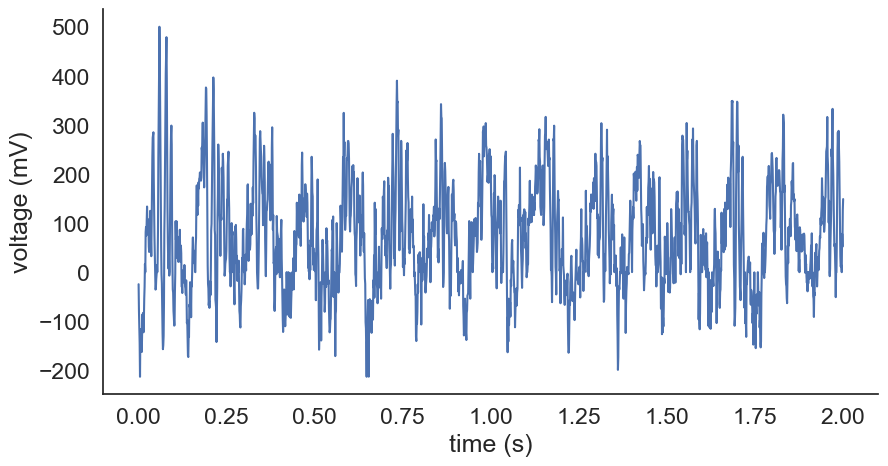

In [17]:
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,2,2000),lfp[:2000])
plt.xlabel('time (s)')
plt.ylabel('voltage (mV)')

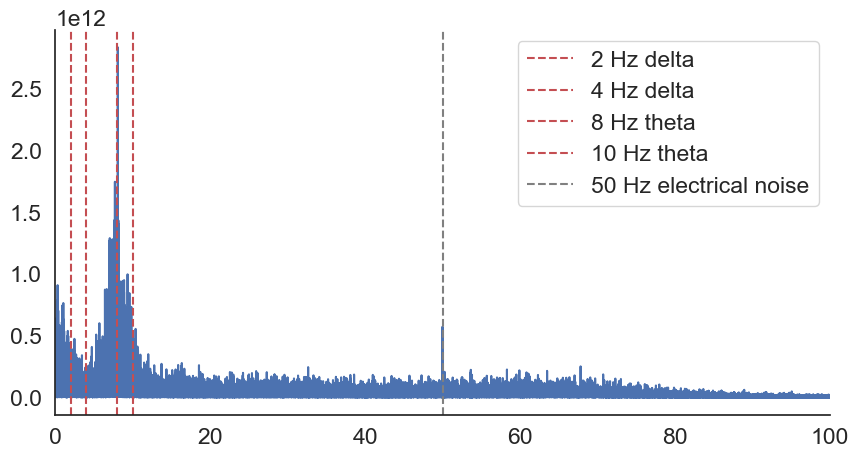

In [18]:
from scipy.fft import fft, fftfreq

n_samples = len(lfp)
sample_dt = 1. / sampling_rate

# we subtract the mean to get rid of the 0 frequency component in the spectrum
centered_lfp = lfp - np.mean(lfp)

transformed_signal = fft(centered_lfp) 

frequencies = fftfreq(n_samples,sample_dt) 

transformed_signal = transformed_signal[:n_samples//2]
frequencies = frequencies[:n_samples//2]

power = abs(transformed_signal)**2

plt.figure(figsize = (10,5))
plt.plot(frequencies,power)
plt.xlim([0,100]) # restrict to 
plt.axvline(x=2 ,c='r',linestyle='--',label='2 Hz delta')
plt.axvline(x=4 ,c='r',linestyle='--',label='4 Hz delta')
plt.axvline(x=8 ,c='r',linestyle='--',label='8 Hz theta')
plt.axvline(x=10 ,c='r',linestyle='--',label='10 Hz theta')
plt.axvline(x=50 ,c='grey',linestyle='--',label='50 Hz electrical noise')

plt.legend()


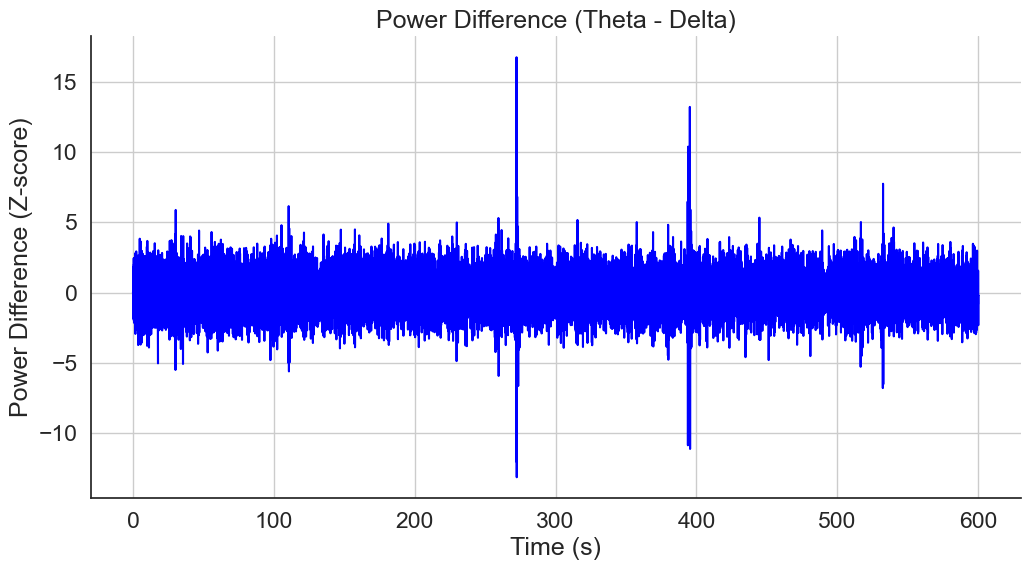

[-2.52455015e-05 -2.52472663e-05 -2.52577467e-05 ...  1.25668975e+00
  1.23134331e+00  1.20220034e+00]
[-1.56322086e-04 -1.56322227e-04 -1.56323067e-04 ...  1.44988105e+00
  1.42340738e+00  1.39613267e+00]
[-2.37648867e-10 -3.12430743e-09 -2.03569684e-08 ...  2.97421215e+01
  2.91991126e+01  2.86396735e+01]
[-7.45316139e-09 -9.76058580e-08 -6.33011826e-07 ...  6.42010169e+01
  6.29061591e+01  6.14173501e+01]
[ 1.31076585e-04  1.31074961e-04  1.31065321e-04 ... -1.93191304e-01
 -1.92064071e-01 -1.93932338e-01]


In [19]:
from scipy.stats import zscore
from scipy.signal import butter
from scipy.signal import sosfilt

filter_order = 7 #the higher the order, the sharper the filter frequency response, 
                 #but with more computations and potental numerical instability (6-10 Hz) and delta (2-4 Hz)

delta_lfp = lf.bandpass_filter(lfp,low_f=2,high_f=4, sampling_rate=sampling_rate)
theta_lfp = lf.bandpass_filter(lfp,low_f=6,high_f=10, sampling_rate=sampling_rate)

#apply filter to lfp       
wideband_lfp1 = sosfilt(filter1, lfp)
wideband_lfp2= sosfilt(filter2, lfp)

#zscore the delta_lfp and theta_lfp
delta_power_zscore = zscore(delta_lfp)
theta_power_zscore = zscore(theta_lfp)

power_difference = theta_power_zscore - delta_power_zscore


plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(power_difference)) / sampling_rate, power_difference, color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Power Difference (Z-score)')
plt.title('Power Difference (Theta - Delta)')
plt.grid(True)
plt.show()

print(theta_power_zscore)
print(delta_power_zscore)

print(delta_lfp)
print(theta_lfp)

print(power_difference)

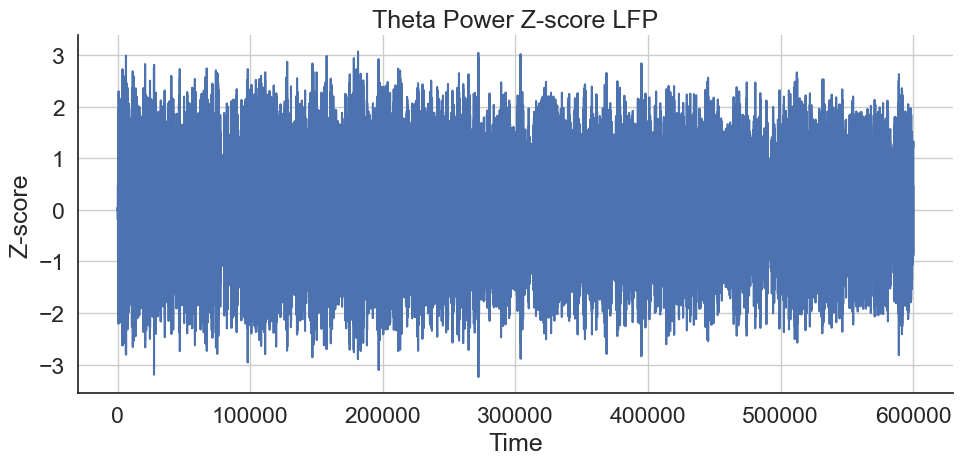

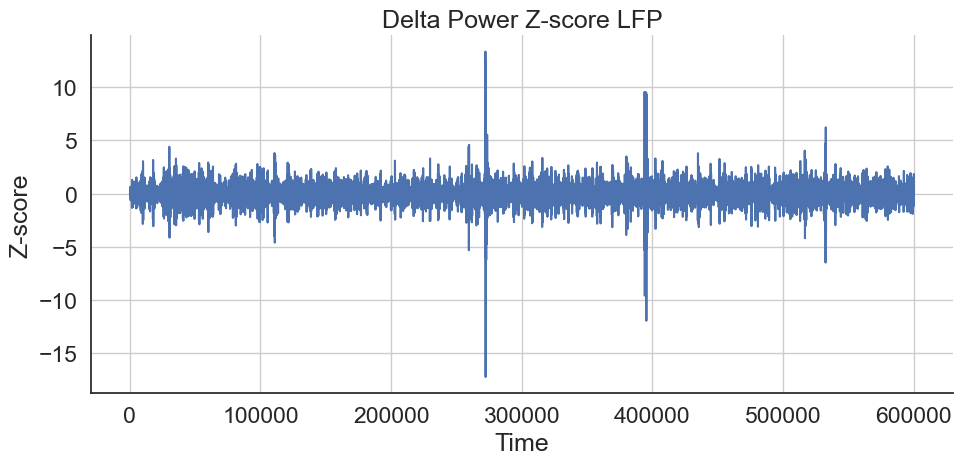

In [20]:
import matplotlib.pyplot as plt

# Assuming you have theta_power_zscore_lfp and delta_power_zscore_lfp data available

# Plot theta_power_zscore_lfp
plt.figure(figsize=(10, 5))
plt.plot(theta_power_zscore)
plt.title('Theta Power Z-score LFP')
plt.xlabel('Time')
plt.ylabel('Z-score')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot delta_power_zscore_lfp
plt.figure(figsize=(10, 5))
plt.plot(delta_power_zscore)
plt.title('Delta Power Z-score LFP')
plt.xlabel('Time')
plt.ylabel('Z-score')
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
# Define thresholds for REM and nREM sleep periods
rem_threshold = 0.2
nrem_threshold = -0.2

# Step 3: Identify REM and nREM sleep periods
rem_periods = np.where(power_difference > rem_threshold)[0]
nrem_periods = np.where(power_difference < nrem_threshold)[0]

# Print the identified sleep periods
print("REM Sleep Periods:")
print(rem_periods)

print("\nnREM Sleep Periods:")
print(nrem_periods)

REM Sleep Periods:
[   186    187    188 ... 600019 600020 600021]

nREM Sleep Periods:
[   134    135    136 ... 600126 600127 600128]


In [22]:
import matplotlib.pyplot as plt

# Load the data
with open('data/moving_lfp.pickle', 'rb') as f:
    data = pickle.load(f)

# Define time axis
time_axis = np.arange(len(data['lfp'])) / data['sampling_rate']

# Create a plot
plt.figure(figsize=(10, 5))


# Plot REM periods
[plt.axvsan(rem_period / data['sampling_rate'], (rem_period + 1) / data['sampling_rate'], color='blue', alpha=0.3) for rem_period in rem_periods]

# Plot nREM periods
[plt.axvspan(nrem_period / data['sampling_rate'], (nrem_period + 1) / data['sampling_rate'], color='red', alpha=0.3) for nrem_period in nrem_periods]


# Customize plot
plt.title('REM and nREM Periods')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(['REM', 'nREM'], loc='upper right')
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


AttributeError: module 'matplotlib.pyplot' has no attribute 'axvsan'

<Figure size 1000x500 with 0 Axes>

The loading of the plot is not possible, it takes to long so therefore, I cant analyse the nREM and REM periods.

Text(0, 0.5, 'voltage (mV)')

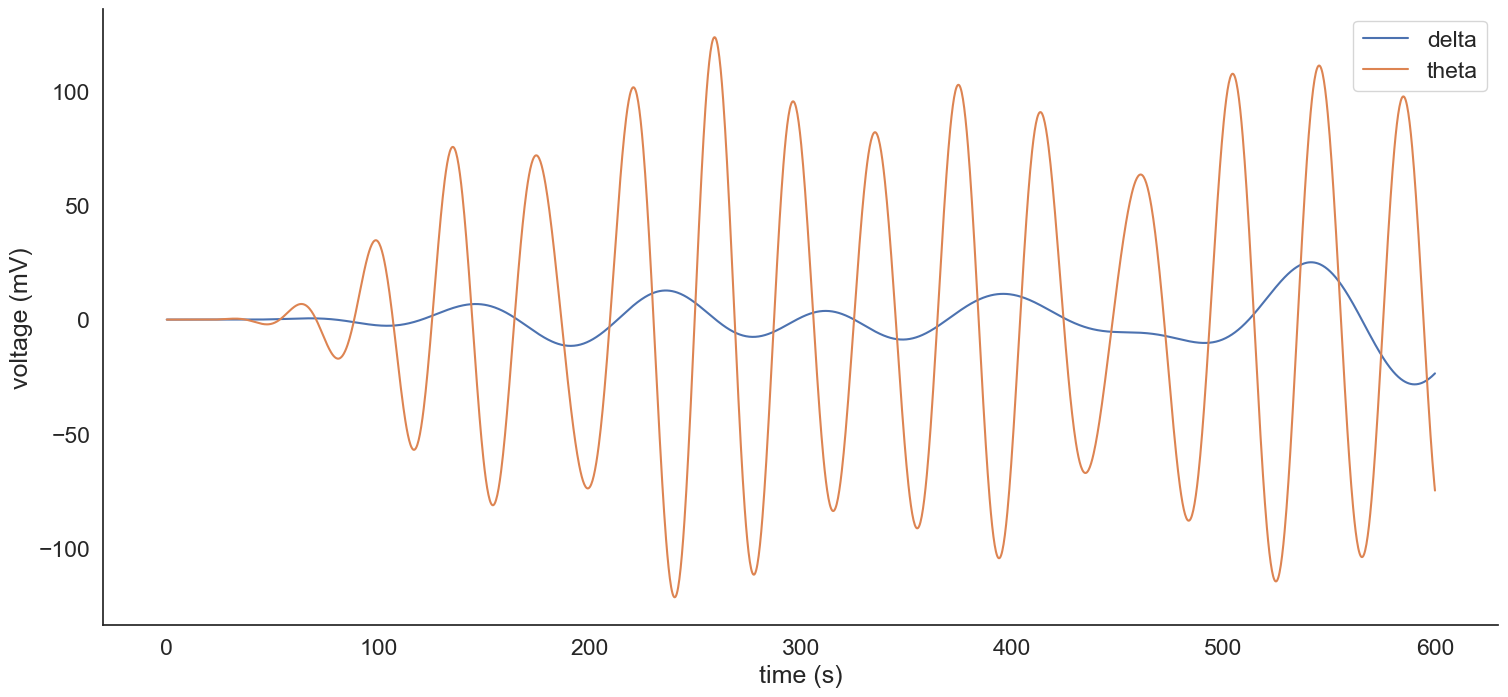

In [ ]:
from scipy.signal import butter
from scipy.signal import sosfilt

filter_order = 7 #the higher the order, the sharper the filter frequency response, 
                 #but with more computations and potental numerical instability (6-10 Hz) and delta (2-4 Hz)
low_f1 = 2
high_f1 = 4

low_f2 = 6
high_f2 = 10

#define filter object
filter1 = butter(filter_order,[low_f1,high_f1],
                btype='band', 
                output='sos', 
                fs=sampling_rate)

filter2 = butter(filter_order,[low_f2,high_f2],
                btype='band', 
                output='sos', 
                fs=sampling_rate)

                
#apply filter to lfp       
wideband_lfp1 = sosfilt(filter1, lfp)
wideband_lfp2= sosfilt(filter2, lfp)

plt.figure(figsize=(18,8))
plt.plot(np.linspace(0,600,2000),wideband_lfp1[:2000],label = 'delta')
plt.plot(np.linspace(0,600,2000),wideband_lfp2[:2000],label = 'theta')
plt.xlabel('time (s)')
plt.legend()
plt.ylabel('voltage (mV)')

Text(0, 0.5, 'voltage (mV)')

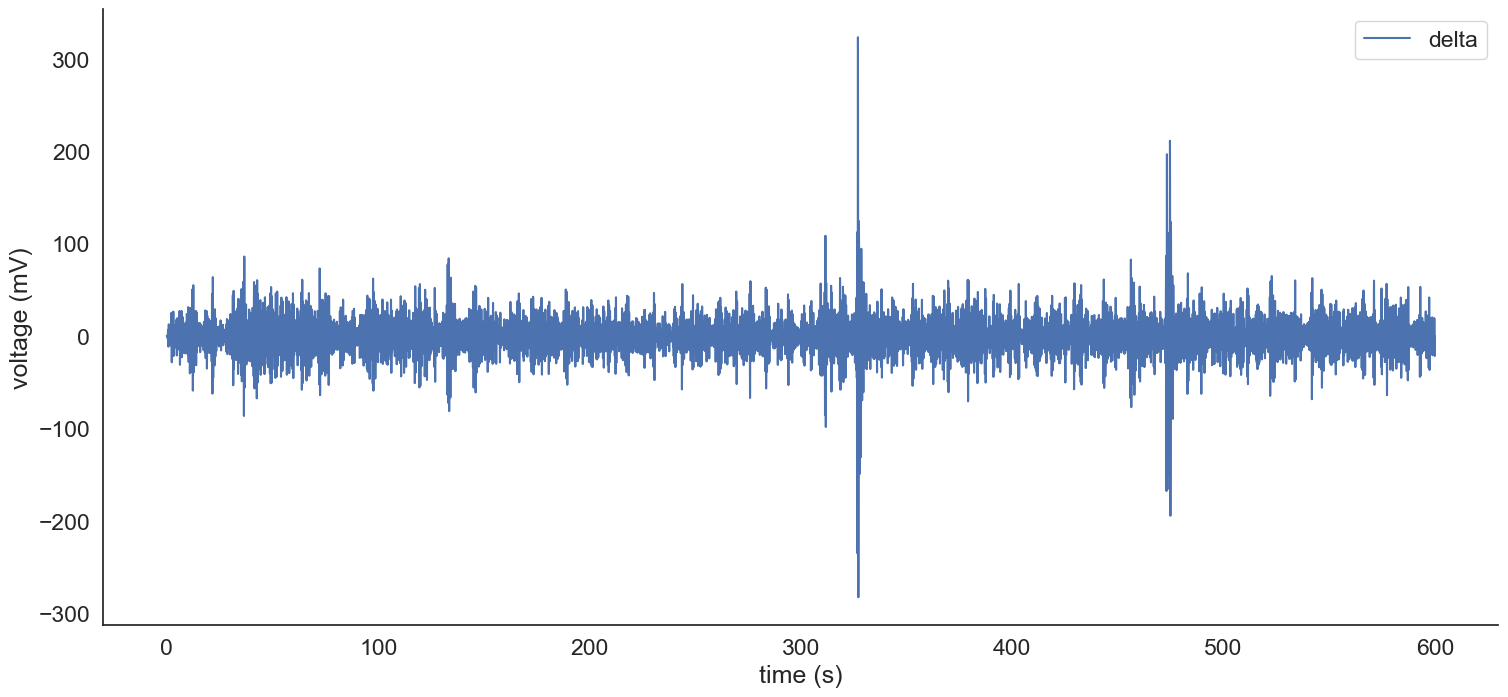

In [ ]:
from scipy.signal import butter
from scipy.signal import sosfilt

filter_order = 7 #the higher the order, the sharper the filter frequency response, 
                 #but with more computations and potental numerical instability (6-10 Hz) and delta (2-4 Hz)
low_f1 = 2
high_f1 = 4


#define filter object
filter1 = butter(filter_order,[low_f1,high_f1],
                btype='band', 
                output='sos', 
                fs=sampling_rate)

#apply filter to lfp       
wideband_lfp1 = sosfilt(filter1, lfp)


plt.figure(figsize=(18,8))
plt.plot(np.linspace(0,600,500000),wideband_lfp1[:500000],label = 'delta')
plt.xlabel('time (s)')
plt.legend()
plt.ylabel('voltage (mV)')

Text(0, 0.5, 'voltage (mV)')

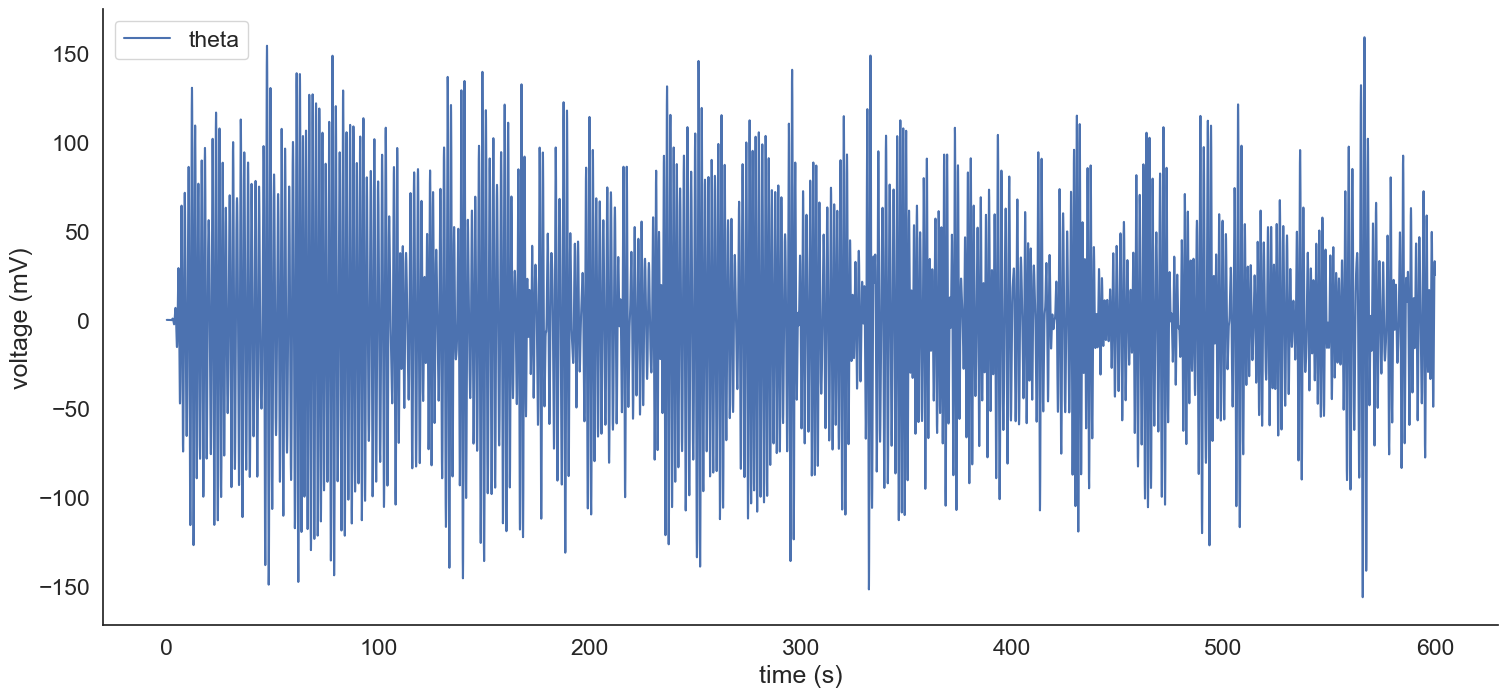

In [ ]:
from scipy.signal import butter
from scipy.signal import sosfilt

filter_order = 10 #the higher the order, the sharper the filter frequency response, 
                 #but with more computations and potental numerical instability
low_f1 = 6
high_f1 = 10

#define filter object
filter1 = butter(filter_order,[low_f1,high_f1],
                btype='band', 
                output='sos', 
                fs=sampling_rate)            
#apply filter to lfp       
wideband_lfp1 = sosfilt(filter1, lfp)


plt.figure(figsize=(18,8))
plt.plot(np.linspace(0,600,50000),wideband_lfp1[:50000],label = 'theta')


plt.xlabel('time (s)')
plt.legend()
plt.ylabel('voltage (mV)')

Text(0, 0.5, 'voltage (mV)')

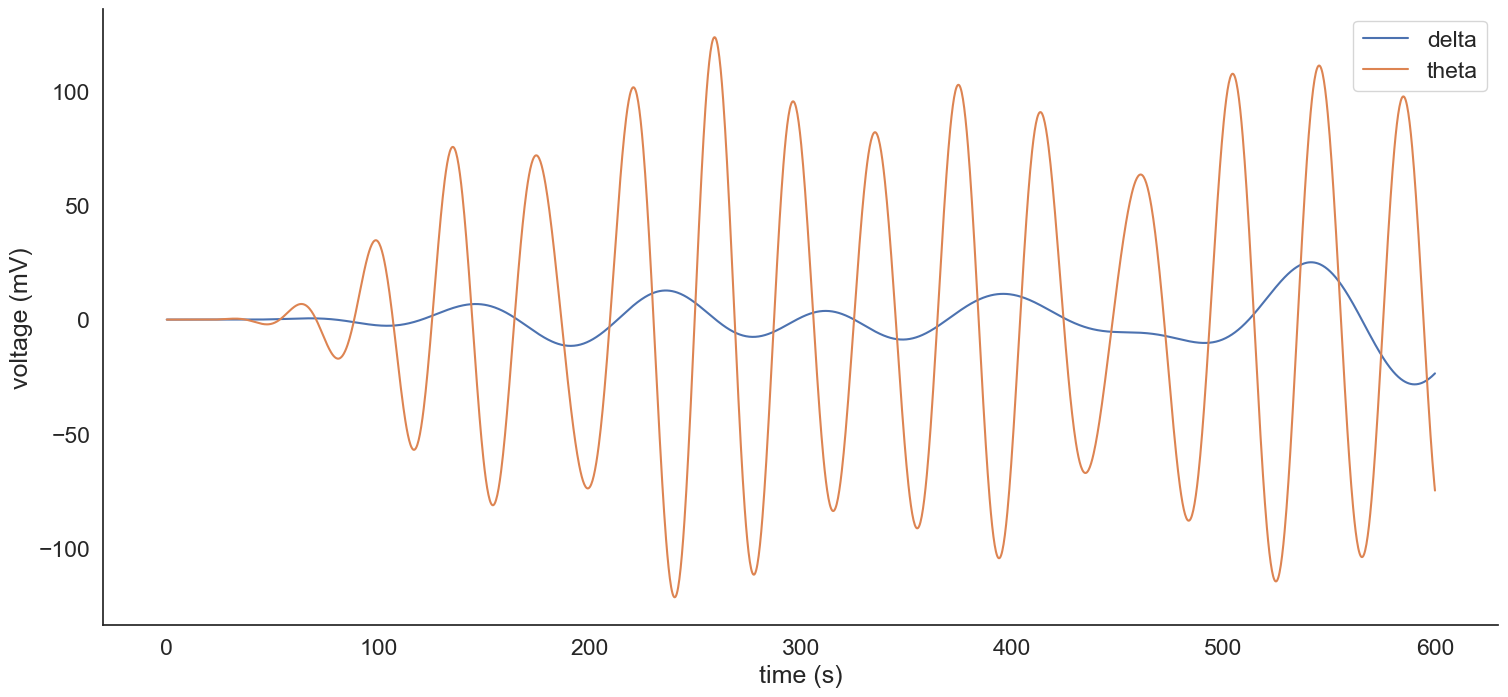

In [ ]:
from scipy.signal import butter
from scipy.signal import sosfilt

filter_order = 7 #the higher the order, the sharper the filter frequency response, 
                 #but with more computations and potental numerical instability (6-10 Hz) and delta (2-4 Hz)
low_f1 = 2
high_f1 = 4

low_f2 = 6
high_f2 = 10

#define filter object
filter1 = butter(filter_order,[low_f1,high_f1],
                btype='band', 
                output='sos', 
                fs=sampling_rate)

filter2 = butter(filter_order,[low_f2,high_f2],
                btype='band', 
                output='sos', 
                fs=sampling_rate)

                
#apply filter to lfp       
wideband_lfp1 = sosfilt(filter1, lfp)
wideband_lfp2= sosfilt(filter2, lfp)

plt.figure(figsize=(18,8))
plt.plot(np.linspace(0,600,2000),wideband_lfp1[:2000],label = 'delta')
plt.plot(np.linspace(0,600,2000),wideband_lfp2[:2000],label = 'theta')
plt.xlabel('time (s)')
plt.legend()
plt.ylabel('voltage (mV)')

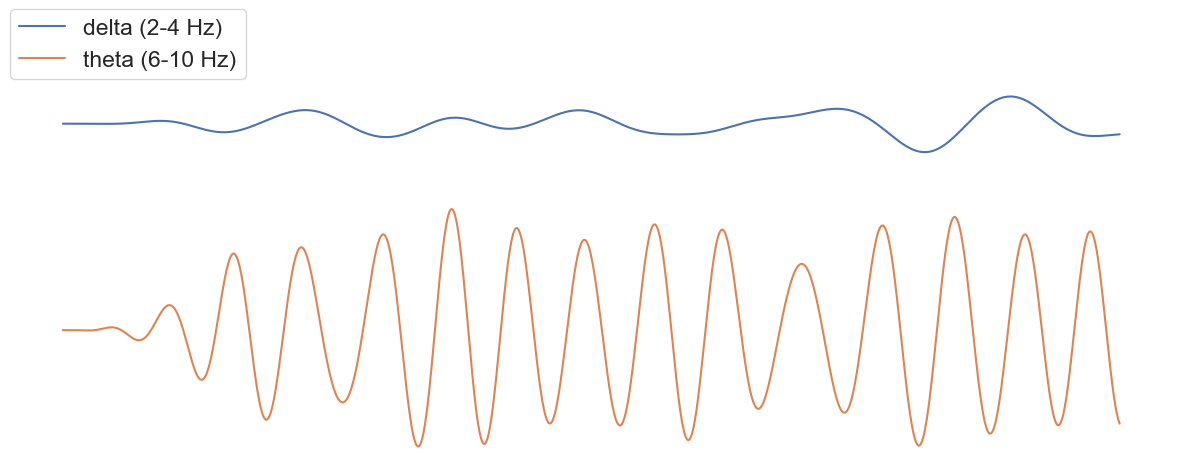

In [ ]:
theta_lfp = lf.bandpass_filter(lfp,low_f=2,high_f=4, sampling_rate=sampling_rate)
slow_gamma_lfp = lf.bandpass_filter(lfp,low_f=6,high_f=10, sampling_rate=sampling_rate)


plot_offset = 200 #to plot the signal on different lines

plt.figure(figsize=(15,5))

plt.plot(theta_lfp[:2000]+2*plot_offset,label='delta (2-4 Hz)')
plt.plot(slow_gamma_lfp[:2000]+plot_offset,label = 'theta (6-10 Hz)')


plt.axis('off')
plt.legend(loc=(0,1))